In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, accuracy_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

1) Load data

In [6]:
df = pd.read_csv("/content/cellula toxic data .csv")

df = df.copy()
df["query"] = df["query"].fillna("").astype(str)
df["image descriptions"] = df["image descriptions"].fillna("").astype(str)
df["Toxic Category"] = df["Toxic Category"].fillna("").astype(str)

df["text"] = df["query"] + " [SEP] " + df["image descriptions"]
df = df[df["text"].str.strip() != ""].reset_index(drop=True)

2) Encode labels

In [7]:
le = LabelEncoder()
y = le.fit_transform(df["Toxic Category"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_), "| Num classes:", num_classes)

Classes: ['Child Sexual Exploitation', 'Elections', 'Non-Violent Crimes', 'Safe', 'Sex-Related Crimes', 'Suicide & Self-Harm', 'Unknown S-Type', 'Violent Crimes', 'unsafe'] | Num classes: 9


3) Train/Val/Test split

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df["text"].values, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


4) tf.data

In [9]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)


5) TextVectorization

In [10]:
MAX_TOKENS = 20000
SEQ_LEN = 120

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQ_LEN
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(256))


6) Build LSTM model

In [11]:
EMBED_DIM = 128
LSTM_UNITS = 128

inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=MAX_TOKENS, output_dim=EMBED_DIM, mask_zero=True)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]  # Keras will track accuracy; F1 we'll compute via callback below
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 120)       │          0 │ input_layer[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 128)  │  2,560,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 120)       │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9)         │      2,313 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,825,481 (10.78 MB)

 Trainable params: 2,825,481 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- F1 callback (computes val F1 each epoch) ---
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, average="macro"):
        super().__init__()
        self.val_data = val_data
        self.average = average
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        y_true = []
        y_pred = []
        for x_batch, y_batch in self.val_data:
            probs = self.model.predict(x_batch, verbose=0)
            preds = np.argmax(probs, axis=1)
            y_true.extend(y_batch.numpy().tolist())
            y_pred.extend(preds.tolist())

        f1 = f1_score(y_true, y_pred, average=self.average)
        self.val_f1s.append(f1)
        logs["val_f1"] = f1  # so it appears in History
        print(f"\nval_f1 ({self.average}) = {f1:.4f}")

f1_cb = F1Callback(val_ds, average="macro")

callbacks = [
    f1_cb,
    tf.keras.callbacks.EarlyStopping(monitor="val_f1", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

7) Train

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5115 - loss: 1.5600
val_f1 (macro) = 0.4779
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 553ms/step - accuracy: 0.5134 - loss: 1.5533 - val_accuracy: 0.8200 - val_loss: 0.4632 - val_f1: 0.4779 - learning_rate: 0.0010
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8584 - loss: 0.3818
val_f1 (macro) = 0.6793
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.8587 - loss: 0.3813 - val_accuracy: 0.8900 - val_loss: 0.2942 - val_f1: 0.6793 - learning_rate: 0.0010
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9417 - loss: 0.1848
val_f1 (macro) = 0.9460
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 524ms/step - accuracy: 0.9419 - loss: 0.1844 - val_accuracy: 0.9600 - val_loss: 0.1448 - val_f1: 0.9460 - learning_rate: 0.0010
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9894 - loss: 0.0529
val_f1 (macro) = 0.9381
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.9893 - loss: 0.0530 - val_a

 8) Evaluate on test

In [14]:
test_probs = model.predict(test_ds, verbose=0)
test_pred = np.argmax(test_probs, axis=1)

test_acc = accuracy_score(y_test, test_pred)
test_f1_macro = f1_score(y_test, test_pred, average="macro")
test_f1_weighted = f1_score(y_test, test_pred, average="weighted")

In [16]:
print("\nTest accuracy:", test_acc)
print("Test F1 macro:", test_f1_macro)
print("Test F1 weighted:", test_f1_weighted)
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=le.classes_))


Test accuracy: 0.9633333333333334
Test F1 macro: 0.9524972473181725
Test F1 weighted: 0.958191309867722

Classification report:
                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        10
                Elections       1.00      1.00      1.00        11
       Non-Violent Crimes       0.97      1.00      0.98        30
                     Safe       0.91      1.00      0.95       100
       Sex-Related Crimes       1.00      1.00      1.00        11
      Suicide & Self-Harm       1.00      1.00      1.00        12
           Unknown S-Type       1.00      0.47      0.64        19
           Violent Crimes       1.00      0.99      0.99        79
                   unsafe       1.00      1.00      1.00        28

                 accuracy                           0.96       300
                macro avg       0.99      0.94      0.95       300
             weighted avg       0.97      0.96      0.96       30

9) Graphs

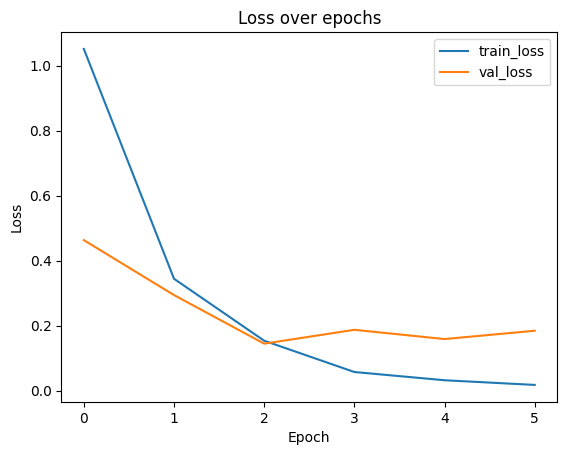

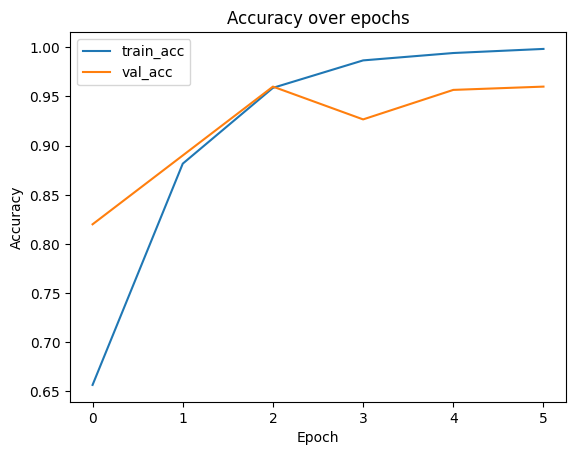

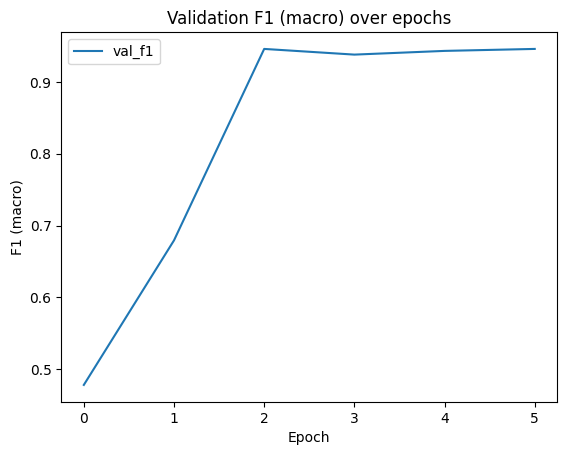

In [17]:
hist = history.history

plt.figure()
plt.plot(hist.get("loss", []))
plt.plot(hist.get("val_loss", []))
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

plt.figure()
plt.plot(hist.get("accuracy", []))
plt.plot(hist.get("val_accuracy", []))
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.figure()
plt.plot(hist.get("val_f1", []))
plt.title("Validation F1 (macro) over epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.legend(["val_f1"])
plt.show()


10) Confusion matrix

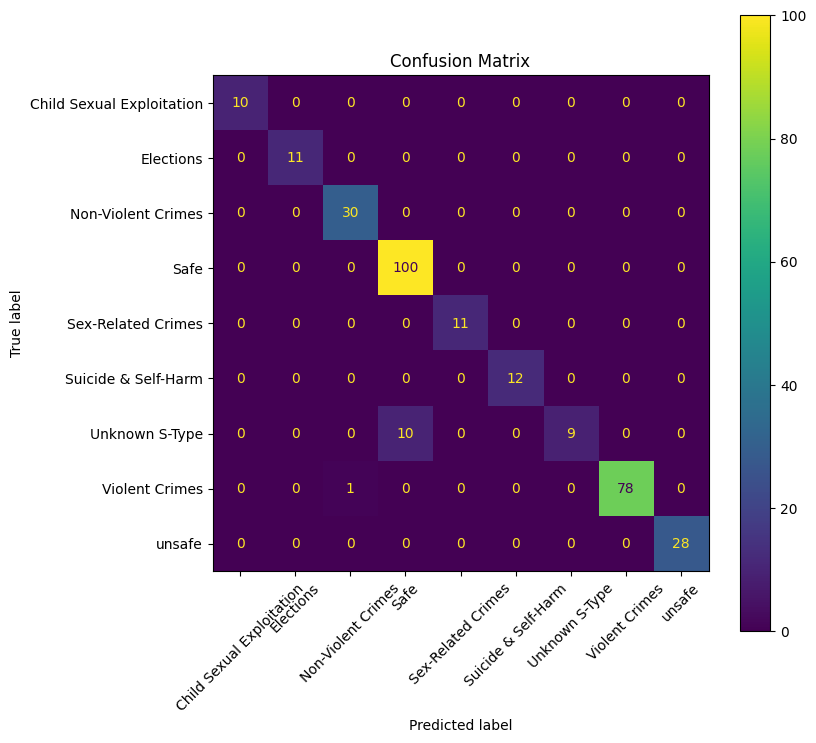

In [18]:
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()